<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Комментарий-ревьювера" data-toc-modified-id="Комментарий-ревьювера-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Комментарий ревьювера</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем библиотеки

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

Загружаем данные

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
except:
    data = pd.read_csv('D:\\taxi.csv', parse_dates=[0], index_col=[0])

Проверяем, что индекс монотонный

In [3]:
print(data.index.is_monotonic)

True


Ресемплируем данные по одному часу

In [4]:
data = data.resample('1H').sum()

## Анализ

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


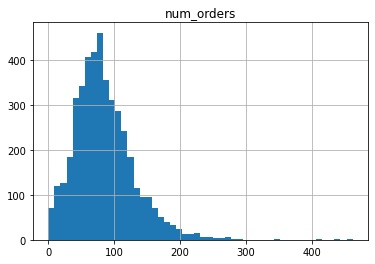

In [5]:
data.info()
print(data.describe())
data.hist(bins=50);
data.head(20)

Данные имеют близкое к нормальному распределение и хвост справа

Посмотрим на тренд, сезонность и остатки ряда

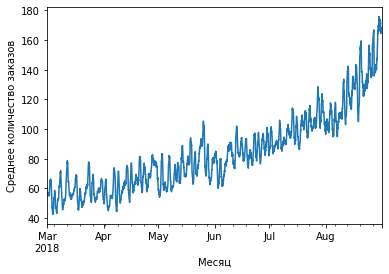

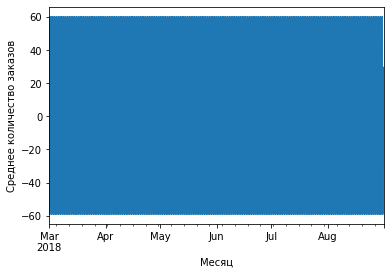

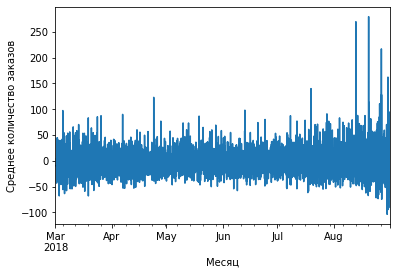

In [6]:
decomposed = seasonal_decompose(data)
decomposed.trend.plot();
plt.xlabel('Месяц')
plt.ylabel('Среднее количество заказов')
plt.show()
decomposed.seasonal.plot();
plt.xlabel('Месяц')
plt.ylabel('Среднее количество заказов')
plt.show()
decomposed.resid.plot();
plt.xlabel('Месяц')
plt.ylabel('Среднее количество заказов')
plt.show()

Видим хороший восходящий тренд - среднее количество заказов увеличилось с 60 до 160 за пол года. А вот сезонность не разглядеть - слишком крупный для неё временной промежуток. Выведем недельную и дневную сезонность

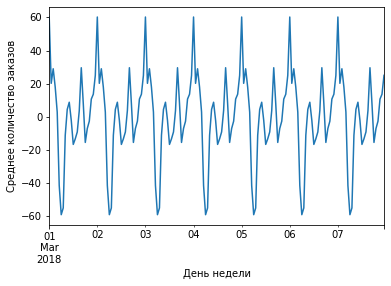

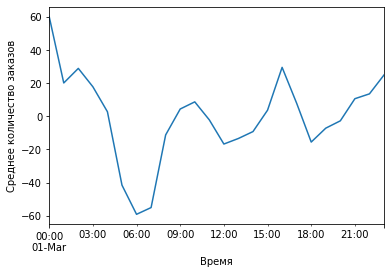

In [7]:
decomposed.seasonal['2018-03':'2018-03-07'].plot();
plt.xlabel('День недели')
plt.ylabel('Среднее количество заказов')
plt.show()
decomposed.seasonal['2018-03-01':'2018-03-01'].plot();
plt.xlabel('Время')
plt.ylabel('Среднее количество заказов')
plt.show()

Обнаружили зависимость от часа - в течении дня точка, когда заказов больше всего - около полуночи, затем количество заказов снижается и идёт в точку наименьшего количества заказов - в 6 утра. После этого график растёт и падает с трендом вверх пока снова не оказывается в максимальной точке полуночи

Попробуем ресемплировать ряд и посмотреть на то, какая будет сезонность при укрупнении интервала ряда до дня и недели

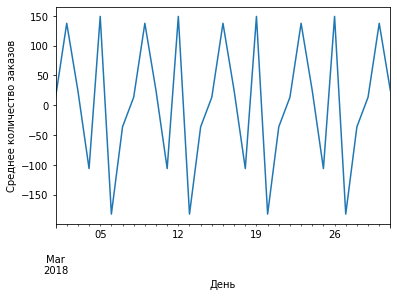

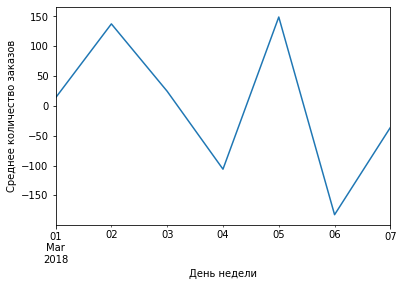

In [8]:
decomposed = seasonal_decompose(data.resample('1d').sum())
decomposed.seasonal['2018-03':'2018-03'].plot();
plt.xlabel('День')
plt.ylabel('Среднее количество заказов')
plt.show()
decomposed.seasonal['2018-03':'2018-03-07'].plot();
plt.xlabel('День недели')
plt.ylabel('Среднее количество заказов')
plt.show()

In [9]:
try:
    decomposed = seasonal_decompose(data.resample('7d').sum())
    decomposed.seasonal.plot();
    plt.show()
    decomposed.seasonal['2018-03':'2018-03'].plot();
    plt.show()
    decomposed.seasonal['2018-03':'2018-03-07'].plot();
    plt.show()
except:
    print('Не получилось получить статистику при ресмплировании по неделям')

Не получилось получить статистику при ресмплировании по неделям


Посмотреть на статистику по неделям не получилось - данных за пол года не хватает для получения каких-то выводов. А вот при интервале в день мы смогли увидеть, что день недели существенно влияет на количество заказов - если график зависимости от времени дня имел интервал от +60 до -60, то этот имеет от +150 до -150. Зависимости от месяца и дня месяца мы не обнаружили -  это не значит, что её нет, но если она есть, то просто не может проявить себя на данных за пол года.

Переходим к обучению моделей

## Обучение

Определяем функцию создания параметров для обучения

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Определяем функцию деления данных на обучающую и тестовую выборки, с выделением из обучающей выборки валидационной

In [11]:
def split_data(data):
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()
    train_valid, valid = train_test_split(train, shuffle=False, test_size=0.15)

    global X_train_valid, y_train_valid, X_valid, y_valid

    X_train_valid = train_valid.drop('num_orders', axis=1)
    y_train_valid = train_valid['num_orders']

    X_valid = valid.drop('num_orders', axis=1)
    y_valid = valid['num_orders']

Для обучения используем три модели - линейную регрессию, случайный лес и CatBoost. Переберём небольшое количество параметров и гиперпараметров чтобы определить лучшее сочетание и модель на нём, результаты запишем в таблицу. У признаков переберём количество разностей временного ряда и размер скользящего среднего, т.к. наши данные - заказы по часам, количество разностей временного ряда - данные за последние X часов, переберём по 8 часов значения от суток до двух суток, а размер скользящего среднего - тренд с усреднением по X часов, переберём по 4 часа значения от 4 часов до 16 часов. У леса переберём максимальное значение глубины, у CatBoost сравним размер шага

In [12]:
%%time

depth_values = [8, 12, 16, 20]
learning_values = [0.1, 0.05]
results = []
lin_reg = LinearRegression()

# цикл для перебора различного сочетания параметров, выводим текущие параметры
for lag in range(24, 49, 8):
    for roll_size in range(4, 17, 4):
        print('Количество разностей временного ряда -', lag, 'размер скользящего среднего -', roll_size)
        # перезаписываем переменную train_data и создаём в ней новые параметры, разбиваем её на выборки
        train_data = data.copy()
        make_features(train_data, lag, roll_size)
        split_data(train_data)
        #обучаем линейную регрессию, выводим результат обучения и сохраняем его в таблицу
        lin_reg.fit(X_train_valid, y_train_valid)
        rmse = mean_squared_error(y_valid, lin_reg.predict(X_valid), squared=False)
        print('RMSE линейной регрессии -', rmse)
        result = ['LinearRegression', lag, roll_size, rmse, '-']
        results.append(result)
        # перебераем значения depth для forest и learning_rate для cat, выводим и записываем
        for depth in depth_values:
            forest = RandomForestRegressor(max_depth=depth, random_state=113)
            forest.fit(X_train_valid, y_train_valid)
            rmse = mean_squared_error(y_valid, forest.predict(X_valid), squared=False)
            print('Максимальная глубина -', depth, 'RMSE случайного леса -', rmse)
            result = ['RandomForest', lag, roll_size, rmse, depth]
            results.append(result)
        for rate in learning_values:
            cat = CatBoostRegressor(depth=6 ,learning_rate=rate, verbose=False, random_state=113)
            cat.fit(X_train_valid, y_train_valid)
            rmse = mean_squared_error(y_valid, cat.predict(X_valid), squared=False)
            print('Размер шага -', rate, 'RMSE CatBoost -', rmse)
            result = ['CatBoost', lag, roll_size, rmse, rate]
            results.append(result)

Количество разностей временного ряда - 24 размер скользящего среднего - 4
RMSE линейной регрессии - 33.154889901494556
Максимальная глубина - 8 RMSE случайного леса - 34.02451443549524
Максимальная глубина - 12 RMSE случайного леса - 32.99815133376284
Максимальная глубина - 16 RMSE случайного леса - 32.764553904303796
Максимальная глубина - 20 RMSE случайного леса - 32.87188606696619
Размер шага - 0.1 RMSE CatBoost - 31.595815978630974
Размер шага - 0.05 RMSE CatBoost - 31.56645648371533
Количество разностей временного ряда - 24 размер скользящего среднего - 8
RMSE линейной регрессии - 33.15488990149456
Максимальная глубина - 8 RMSE случайного леса - 33.98447836421741
Максимальная глубина - 12 RMSE случайного леса - 32.54152002450842
Максимальная глубина - 16 RMSE случайного леса - 32.218439201770614
Максимальная глубина - 20 RMSE случайного леса - 32.21423043858523
Размер шага - 0.1 RMSE CatBoost - 31.99757100042296
Размер шага - 0.05 RMSE CatBoost - 31.862302652919674
Количество разн

In [13]:
columns = ['Алгоритм обучения', 'Количество разностей временного ряда',
           'Размер скользящего среднего', 'Значение ошибки', 'Глубина/Размер шага']
results_df = pd.DataFrame(results, columns=columns)
results_df.head(7)

,Алгоритм обучения,Количество разностей временного ряда,Размер скользящего среднего,Значение ошибки,Глубина/Размер шага
0,LinearRegression,24,4,33.154890,-
1,RandomForest,24,4,34.024514,8
2,RandomForest,24,4,32.998151,12
3,RandomForest,24,4,32.764554,16
4,RandomForest,24,4,32.871886,20
5,CatBoost,24,4,31.595816,0.1
6,CatBoost,24,4,31.566456,0.05


Отсортируем данные по значению ошибки

In [14]:
results_df.sort_values(by='Значение ошибки').head(20)

,Алгоритм обучения,Количество разностей временного ряда,Размер скользящего среднего,Значение ошибки,Глубина/Размер шага
111,CatBoost,48,16,29.686802,0.05
89,CatBoost,48,4,29.828854,0.1
96,CatBoost,48,8,29.852198,0.1
90,CatBoost,48,4,29.882109,0.05
97,CatBoost,48,8,29.942663,0.05
103,CatBoost,48,12,30.059561,0.1
110,CatBoost,48,16,30.072107,0.1
104,CatBoost,48,12,30.207717,0.05
91,LinearRegression,48,8,30.842021,-
105,LinearRegression,48,16,30.845316,-


Лучший результат показал алгоритм градиентного бустинга CatBoost с размером шага в 0.05 на данных с признаками за последние 48 часов и скользящим средним размером 16

## Тестирование

Подготовим данные с лучшими параметрами и разобъём на обучающую и тестовую выборку

In [15]:
make_features(data, 48, 16)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

Обучим алгоритм CatBoost со размером шага в 0.05

In [16]:
cat = CatBoostRegressor(depth=6, learning_rate=0.05, verbose=999, random_state=113)
cat.fit(X_train, y_train)
print('RMSE CatBoost на тестовых данных-', mean_squared_error(y_test, cat.predict(X_test), squared=False))

0:	learn: 37.8596569	total: 17.4ms	remaining: 17.4s
999:	learn: 9.8632192	total: 12.8s	remaining: 0us
RMSE CatBoost на тестовых данных- 38.71970808314621


RMSE модели на тестовых данных ниже, чем установленый порог в 48 почти на 10 заказов, значит мы добились поставленной задачи

Визуализируем полученные предсказания и сравним их со значениями целевого признака

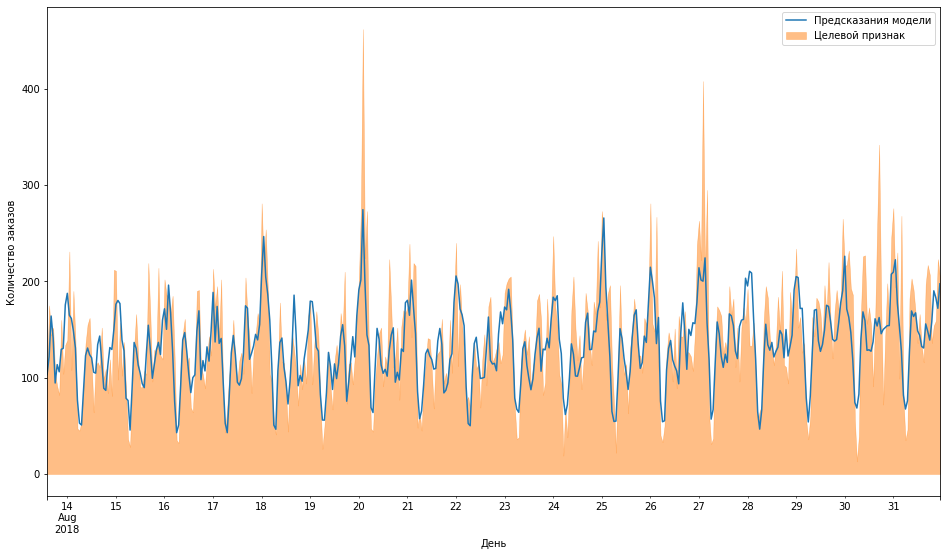

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16,9))
pd.Series(cat.predict(X_test), index=y_test.index).plot(label='Предсказания модели', color='tab:blue');
ax.fill_between(x=y_test.index, y1=y_test, y2=0, label='Целевой признак', alpha=0.5, color='tab:orange', linewidth=0.5)
plt.legend()
plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.show()

## Общий вывод

Мы загрузили временной ряд, проверили его на монотонность и ресемплировали его по необходимому горизонту планирования. Затем мы проанализировали данныые и смогли увидеть общий тренд на повышение, а так же зависимость количества заказов от часа и дня недели. После этого мы перебрали различные сочетания создаваемых нами на основах ряда параметров и гиперпараметров трёх алгоритмов обучения - линейной регрессии, случайного леса и CatBoost, лучший результат из рассмотренных показал CatBoost со скоростью обучения 0.05 на данных с почасовым количеством заказов за последние двое суток и трендом с усреднением по 16 часов. Проверка на тестовой выборке лучшей модели показала значение ошибки по метрике RMSE в 39.5, что меньше установленного порога в 48, поэтому заказ считаем успешно выполненным.